In [1]:
from exojax.atm import amclouds

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# dynamic viscosity in H2 atmosphere (cm/g/s)
T=np.logspace(np.log10(100),np.log10(3000))
eta=amclouds.eta_H2_Rosner(T)

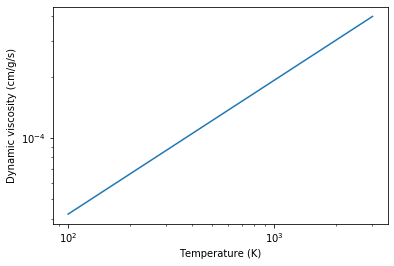

In [7]:
plt.plot(T,eta)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Temperature (K)")
plt.ylabel("Dynamic viscosity (cm/g/s)")
plt.show()